In [1]:
# ─── Standard Library Imports ─────────────────────────────────────────────
import numpy as np                     # For numerical operations and array handling
import matplotlib.pyplot as plt        # For plotting jet images and visualizations
from matplotlib.colors import LogNorm  # For applying logarithmic normalization to color scales in plots
from pathlib import Path               # For handling file and directory paths in a platform-independent way
from sklearn.utils import shuffle      # For shuffling datasets (useful before training/validation split)
from datetime import datetime          # For timestamping logs, files, or outputs

In [2]:
# ─── Define Paths for Quark and Tau Jet Data ────────────────────────────────

# Paths to full jet image batches for quark and tau jets
jj_img_path = Path("/home/soumodip/Python/MSc_Project/Finalized_Project/Training_data_75k_100GeV/JJ_Pipeline/npy_Files_JJ/Full_jet_npy_files")
tau_img_path = Path("/home/soumodip/Python/MSc_Project/Finalized_Project/Training_data_75k_100GeV/Tau_Pipeline/npy_Files_Tau/Full_jet_npy_files")

# Paths to core jet image batches for quark and tau jets
core_qjet_path = Path("/home/soumodip/Python/MSc_Project/Finalized_Project/Training_data_75k_100GeV/JJ_Pipeline/npy_Files_JJ/Core_jet_npy_files")
core_taujet_path = Path("/home/soumodip/Python/MSc_Project/Finalized_Project/Training_data_75k_100GeV/Tau_Pipeline/npy_Files_Tau/Core_jet_npy_files")

# ─── Define Output Directories ──────────────────────────────────────────────

# Base directory for outputs and merged datasets
output_dir_path = Path("/home/soumodip/Python/MSc_Project/Finalized_Project/Training_data_75k_100GeV")

# Paths to save single-event and averaged jet images for visualization
single_image_jet_path   = output_dir_path / "Jet_Images/Single_Event_Full_Jets"
average_jet_path        = output_dir_path / "Jet_Images/Averaged_Full_Jets"
core_img_path           = output_dir_path / "Jet_Images/Single_Event_Core_Jets"
average_core_img_path   = output_dir_path / "Jet_Images/Averaged_Core_Jets"

# Paths to save merged datasets (full and core jet images with metadata)
full_jet_npy_file_path = output_dir_path / "Final_Dataset/Main_Datasets"
core_jet_npy_file_path = output_dir_path / "Final_Dataset/Core_Datasets"

# Path to save logs related to the merging process
log_file_path = output_dir_path / "Final_Dataset/merging.log"

# ─── Logging Function ───────────────────────────────────────────────────────

def log_merge(msg):
    """
    Logs a message with timestamp to both console and log file.
    """
    timestamp = datetime.now().strftime("[%Y-%m-%d %H:%M:%S]")
    line = f"{timestamp} {msg}"
    print(line)
    with open(log_file_path, "a") as f:
        f.write(f"{line}\n")

In [3]:
# ─── Image Grid and Sample Parameters ───────────────────────────────────────

samples_per_class = 24     # Number of sample images to visualize per class
n_rows, n_cols = 12, 4     # Layout for plotting images (12 rows × 4 columns)

# ─── Full Jet Image Configuration ──────────────────────────────────────────

a = 0.8                    # Half-width of full jet image in η–φ plane
eta_range_full = (-a, a)   # Full jet η range
phi_range_full = (-a, a)   # Full jet φ range

# ─── Core Jet Image Configuration ──────────────────────────────────────────

b = 0.2                    # Half-width of core jet image in η–φ plane
eta_range_core = (-b, b)   # Core jet η range
phi_range_core = (-b, b)   # Core jet φ range

# ─── Averaging and Merging Parameters ──────────────────────────────────────

avg_count = 25000          # Number of images to use when computing average images
min_chunk_size = 5000      # Minimum number of images per chunk when merging

In [4]:
def load_and_filter_batches(image_files, label_files, metadata_files, filter_labels, relabel_map):
    """
    Load jet image batches and filter out unwanted labels.
    Relabels the remaining labels using a specified mapping.

    Args:
        image_files (list of Path): Paths to .npy image files.
        label_files (list of Path): Paths to .npy label files.
        metadata_files (list of Path): Paths to .npz metadata files.
        filter_labels (list): Labels to exclude from the dataset.
        relabel_map (dict): Mapping from original labels to new labels.

    Returns:
        Tuple of concatenated arrays: images, labels, pt, eta, phi, n_charged.
    """

    all_images = []
    all_labels = []
    all_pts = []
    all_etas = []
    all_phis = []
    all_n_charged = []

    for img_file, lbl_file, meta_file in zip(image_files, label_files, metadata_files):
        # Load image, label, and metadata for this batch
        images = np.load(img_file)
        labels = np.load(lbl_file)
        metadata = np.load(meta_file)

        pts = metadata["pt"]
        etas = metadata["eta"]
        phis = metadata["phi"]
        n_charged = metadata["n_charged"]

        # Create mask to exclude images with unwanted labels
        mask = ~np.isin(labels, filter_labels)

        # Apply filtering to all arrays
        filtered_images = images[mask]
        filtered_labels = labels[mask]
        filtered_pts = pts[mask]
        filtered_etas = etas[mask]
        filtered_phis = phis[mask]
        filtered_n_charged = n_charged[mask]

        # Relabel remaining labels using the relabel_map
        new_labels = np.array([relabel_map[lbl] for lbl in filtered_labels])

        # Append filtered and relabeled data
        all_images.append(filtered_images)
        all_labels.append(new_labels)
        all_pts.append(filtered_pts)
        all_etas.append(filtered_etas)
        all_phis.append(filtered_phis)
        all_n_charged.append(filtered_n_charged)

    # Concatenate all batches into final dataset
    return (
        np.concatenate(all_images, axis=0),
        np.concatenate(all_labels, axis=0),
        np.concatenate(all_pts, axis=0),
        np.concatenate(all_etas, axis=0),
        np.concatenate(all_phis, axis=0),
        np.concatenate(all_n_charged, axis=0),
    )

In [5]:
# ─── Load and Prepare Quark Jet Data ─────────────────────────────────────────────

# Collect all full quark jet image, label, and metadata file paths
jj_image_files     = sorted(jj_img_path.glob("qjet_imgs_batch_*.npy"))
jj_label_files     = sorted(jj_img_path.glob("qjet_lbls_batch_*.npy"))
jj_metadata_files  = sorted(jj_img_path.glob("qjet_metadata_batch_*.npz"))

# Ensure there is a one-to-one match between image, label, and metadata files
assert len(jj_image_files) == len(jj_label_files) == len(jj_metadata_files), "Mismatch in jj files"

# Define labels to be filtered out (e.g., gluon=2, unmatched=3)
jj_filter_labels = [2, 3]

# Relabel remaining jet types: quark and antiquark both become label 0
jj_relabel_map = {0: 0, 1: 0}

# Load and filter the quark jet batches using the helper function
jj_images, jj_labels, jj_pts, jj_etas, jj_phis, jj_n_charged = load_and_filter_batches(
    jj_image_files,
    jj_label_files,
    jj_metadata_files,
    jj_filter_labels,
    jj_relabel_map
)

# Log summary statistics
log_merge(f"JJ Dataset: {jj_images.shape[0]} jets")
log_merge(f"Label 0 count: {np.sum(jj_labels == 0)}")

[2025-04-22 12:39:30] JJ Dataset: 98241 jets
[2025-04-22 12:39:30] Label 0 count: 98241


In [6]:
# ─── Load and Prepare Tau Jet Data ────────────────────────────────────────────────

# Collect all full tau jet image, label, and metadata file paths
tau_image_files     = sorted(tau_img_path.glob("taujet_imgs_batch_*.npy"))
tau_label_files     = sorted(tau_img_path.glob("taujet_lbls_batch_*.npy"))
tau_metadata_files  = sorted(tau_img_path.glob("taujet_metadata_batch_*.npz"))

# Ensure equal number of image, label, and metadata files for tau jets
assert len(tau_image_files) == len(tau_label_files) == len(tau_metadata_files), "Mismatch in tau files"

# Define labels to be filtered out (e.g., unmatched or other non-tau jets if labeled 2)
tau_filter_labels = [2]

# Relabel both "tau" and "anti-tau" jet labels to a single class (label 1)
tau_relabel_map = {0: 1, 1: 1}

# Load and filter the tau jet batches using the helper function
tau_images, tau_labels, tau_pts, tau_etas, tau_phis, tau_n_charged = load_and_filter_batches(
    tau_image_files,
    tau_label_files,
    tau_metadata_files,
    tau_filter_labels,
    tau_relabel_map
)

# Log summary statistics
log_merge(f"Tau Dataset: {tau_images.shape[0]} jets")
log_merge(f"Label 1 count: {np.sum(tau_labels == 1)}")

[2025-04-22 12:39:30] Tau Dataset: 124537 jets
[2025-04-22 12:39:30] Label 1 count: 124537


In [7]:
# ─── Merge and Shuffle Tau and Quark Jet Data ────────────────────────────────────

# Concatenate tau and quark jet images, labels, and metadata
X = np.concatenate([tau_images, jj_images], axis=0)
y = np.concatenate([tau_labels, jj_labels], axis=0)
pT = np.concatenate([tau_pts, jj_pts], axis=0)
eta = np.concatenate([tau_etas, jj_etas], axis=0)
phi = np.concatenate([tau_phis, jj_phis], axis=0)
n_charged = np.concatenate([tau_n_charged, jj_n_charged], axis=0) 

# Shuffle the combined dataset to ensure class mixing
X, y, pT, eta, phi, n_charged = shuffle(X, y, pT, eta, phi, n_charged, random_state=31)

# Save final merged dataset: images, labels, and associated metadata
np.save(full_jet_npy_file_path / "jet_images.npy", X)
np.save(full_jet_npy_file_path / "jet_labels.npy", y)
np.savez(full_jet_npy_file_path / "jet_metadata.npz", pt=pT, eta=eta, phi=phi, n_charged=n_charged)

# ─── Logging Dataset Statistics ──────────────────────────────────────────────────

log_merge("Final Merged Jet Dataset Summary")
log_merge(f"Total dataset: {X.shape[0]} jets")
log_merge(f"Image shape: {X.shape}")
log_merge(f"Label shape: {y.shape}")

# Log class distribution
class_names = {0: 'Quark', 1: 'Tau'}
unique, counts = np.unique(y, return_counts=True)
log_merge("\nClass distribution:")
for label, count in zip(unique, counts):
    percent = (count / len(y)) * 100
    log_merge(f"  {class_names[label]}: {count} jets  ({percent:.3f}%)")

# Log pixel intensity stats across the entire image dataset
log_merge("\nPixel intensity statistics (across all images):")
log_merge(f"Min intensity:   {np.min(X):.5f}")
log_merge(f"Max intensity:   {np.max(X):.5f}")
log_merge(f"Mean intensity:  {np.mean(X):.5f}")
log_merge(f"Std deviation:   {np.std(X):.5f}")

# Log per-class kinematic statistics
for label in [0, 1]:
    mask = y == label
    class_pts = pT[mask]
    class_eta = eta[mask]
    class_phi = phi[mask]
    class_nchg = n_charged[mask]  

    log_merge(f"\nJet pT stats for {class_names[label]} jets:")
    log_merge(f"Min:    {np.min(class_pts):.5f} GeV")
    log_merge(f"Max:    {np.max(class_pts):.5f} GeV")
    log_merge(f"Mean:   {np.mean(class_pts):.5f} GeV")
    log_merge(f"Std:    {np.std(class_pts):.5f} GeV")

    log_merge(f"\nJet η stats for {class_names[label]} jets:")
    log_merge(f"Min:    {np.min(class_eta):.5f}")
    log_merge(f"Max:    {np.max(class_eta):.5f}")
    log_merge(f"Mean:   {np.mean(class_eta):.5f}")
    log_merge(f"Std:    {np.std(class_eta):.5f}")

    log_merge(f"\nJet φ stats for {class_names[label]} jets:")
    log_merge(f"Min:    {np.min(class_phi):.5f}")
    log_merge(f"Max:    {np.max(class_phi):.5f}")
    log_merge(f"Mean:   {np.mean(class_phi):.5f}")
    log_merge(f"Std:    {np.std(class_phi):.5f}")

    log_merge(f"\nCharged multiplicity stats for {class_names[label]} jets:")
    log_merge(f"Min:    {np.min(class_nchg)}")
    log_merge(f"Max:    {np.max(class_nchg)}")
    log_merge(f"Mean:   {np.mean(class_nchg):.5f}")
    log_merge(f"Std:    {np.std(class_nchg):.5f}")

[2025-04-22 12:39:33] Final Merged Jet Dataset Summary
[2025-04-22 12:39:33] Total dataset: 222778 jets
[2025-04-22 12:39:33] Image shape: (222778, 32, 32)
[2025-04-22 12:39:33] Label shape: (222778,)
[2025-04-22 12:39:33] 
Class distribution:
[2025-04-22 12:39:33]   Quark: 98241 jets  (44.098%)
[2025-04-22 12:39:33]   Tau: 124537 jets  (55.902%)
[2025-04-22 12:39:33] 
Pixel intensity statistics (across all images):
[2025-04-22 12:39:33] Min intensity:   0.00000
[2025-04-22 12:39:33] Max intensity:   1.00000
[2025-04-22 12:39:33] Mean intensity:  0.00098
[2025-04-22 12:39:34] Std deviation:   0.01910
[2025-04-22 12:39:34] 
Jet pT stats for Quark jets:
[2025-04-22 12:39:34] Min:    15.00018 GeV
[2025-04-22 12:39:34] Max:    49.74582 GeV
[2025-04-22 12:39:34] Mean:   34.59707 GeV
[2025-04-22 12:39:34] Std:    8.95128 GeV
[2025-04-22 12:39:34] 
Jet η stats for Quark jets:
[2025-04-22 12:39:34] Min:    -1.83374
[2025-04-22 12:39:34] Max:    1.81759
[2025-04-22 12:39:34] Mean:   0.00040
[20

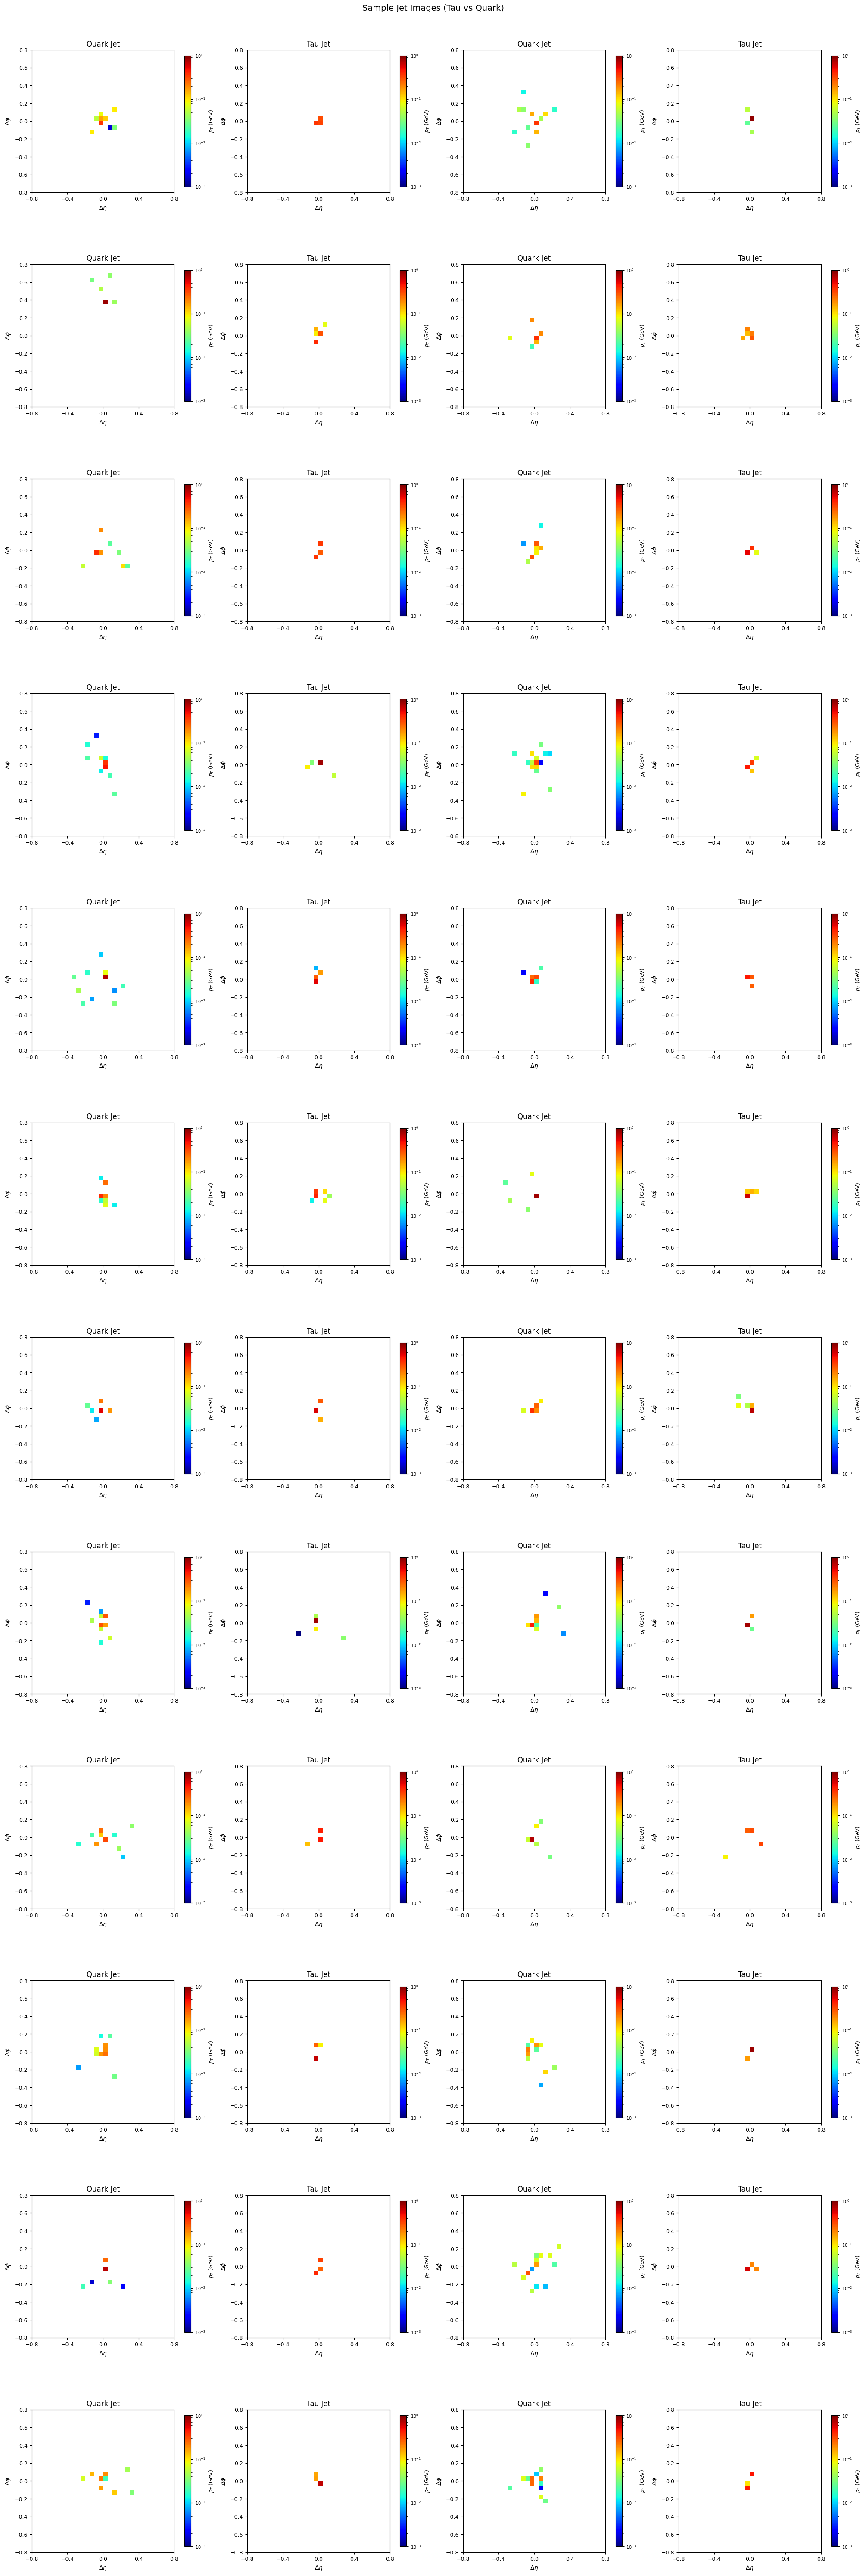

In [8]:
# ─── Select Sample Indices: Equal Number from Each Class ───────────────────────

# Initialize dictionary to store indices of each class
class_indices = {label: [] for label in range(2)}  # 0: Quark, 1: Tau

# Loop through all labels and collect up to `samples_per_class` indices for each class
for idx, label in enumerate(y):
    if len(class_indices[label]) < samples_per_class:
        class_indices[label].append(idx)
    # Stop once both classes have enough samples
    if all(len(v) == samples_per_class for v in class_indices.values()):
        break

# Interleave indices: alternating between quark and tau jet samples
ordered_indices = []
for i in range(samples_per_class):
    for label in range(2):
        ordered_indices.append(class_indices[label][i])

# Counter to keep track of how many images saved per class
saved_count = {0: 0, 1: 0}

# ─── Create a Grid Plot of Jet Images ──────────────────────────────────────────

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), constrained_layout=True)

# Loop over selected indices and plot/save individual images
for plot_idx, data_idx in enumerate(ordered_indices):
    row = plot_idx // n_cols
    col = plot_idx % n_cols
    ax = axs[row, col]

    label = y[data_idx]
    class_name = class_names[label]  # e.g., "Tau" or "Quark"
    
    # Show the jet image in the grid
    im = ax.imshow(X[data_idx], cmap='jet', origin='lower', aspect='equal',
                   norm=LogNorm(vmin=1e-3, vmax=1),
                   extent=[eta_range_full[0], eta_range_full[1], phi_range_full[0], phi_range_full[1]])
    ax.set_title(f"{class_name.capitalize()} Jet", fontsize=12)
    ax.set_xlabel(r'$\Delta \eta$', fontsize=10)
    ax.set_ylabel(r'$\Delta \phi$', fontsize=10)
    ax.set_xticks(np.linspace(phi_range_full[0], phi_range_full[1], 5))
    ax.tick_params(labelsize=9)
    
    # Add colorbar showing pT intensity
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(r'$p_{T}$ (GeV)', fontsize=9)
    cbar.ax.tick_params(labelsize=7)

    # ─── Save Individual Image as Separate File ────────────────────────────────

    fig_single, ax_single = plt.subplots()
    im_single = ax_single.imshow(X[data_idx], cmap='jet', origin='lower', aspect='equal',
                                 norm=LogNorm(vmin=1e-3, vmax=1),
                                 extent=[eta_range_full[0], eta_range_full[1], phi_range_full[0], phi_range_full[1]])
    ax_single.set_title(f"{class_name.capitalize()} Jet", fontsize=10)
    ax_single.set_xlabel(r'$\Delta \eta$', fontsize=10)
    ax_single.set_ylabel(r'$\Delta \phi$', fontsize=10)
    ax.set_xticks(np.linspace(phi_range_full[0], phi_range_full[1], 5))
    ax_single.tick_params(labelsize=9)

    cbar_single = plt.colorbar(im_single, ax=ax_single, fraction=0.046, pad=0.04)
    cbar_single.set_label(r'$p_{T}$ (GeV)', fontsize=10)
    cbar_single.ax.tick_params(labelsize=9)

    # Save the image to disk with appropriate filename
    filename = f"{class_name.lower()}_jet_{saved_count[label]}.png"
    plt.savefig(single_image_jet_path / filename, bbox_inches='tight')
    plt.close(fig_single)

    saved_count[label] += 1  # Increment count for class

# ─── Show Final Tiled Plot of Sample Jet Images ────────────────────────────────

plt.suptitle("Sample Jet Images (Tau vs Quark)", fontsize=14)
plt.show()

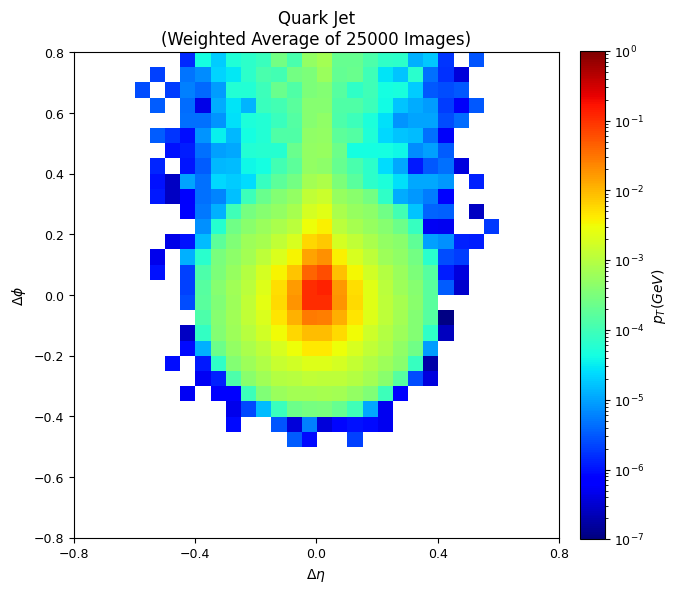

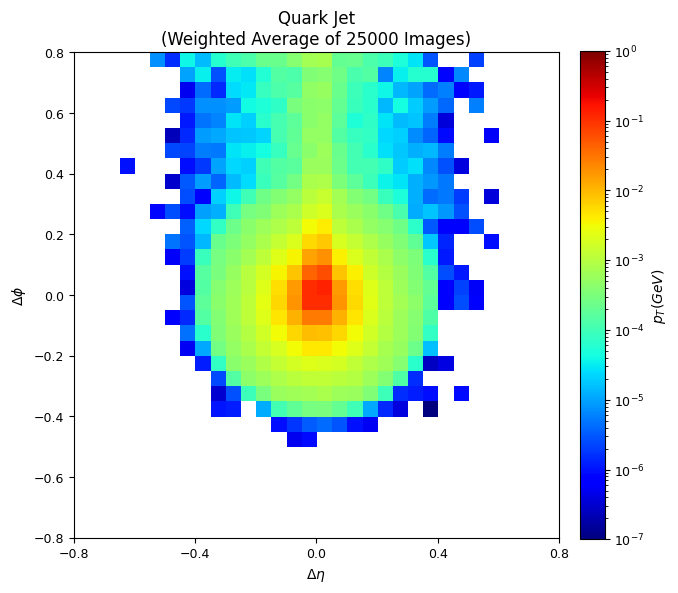

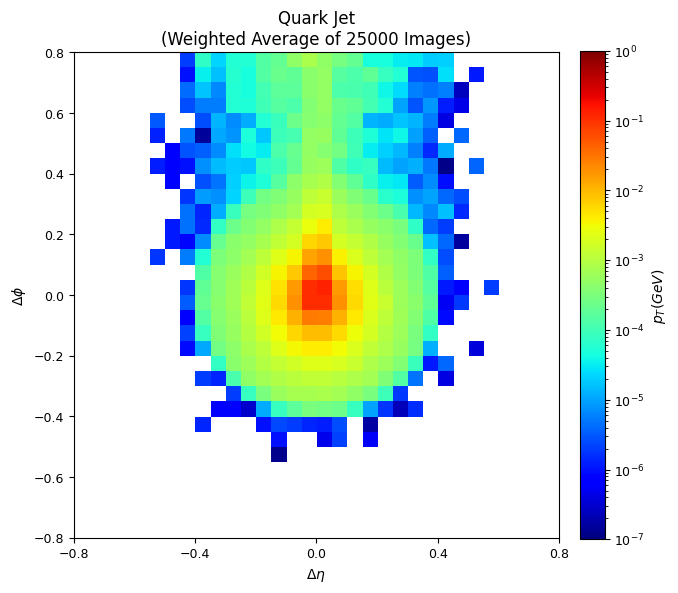

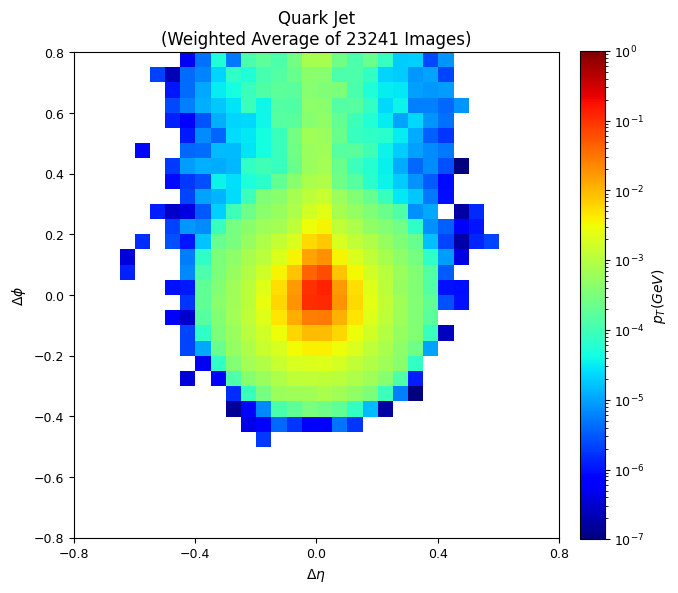

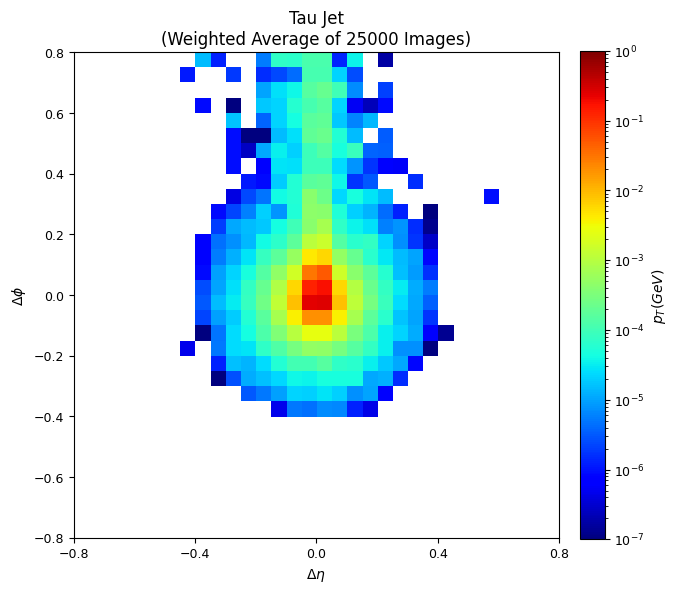

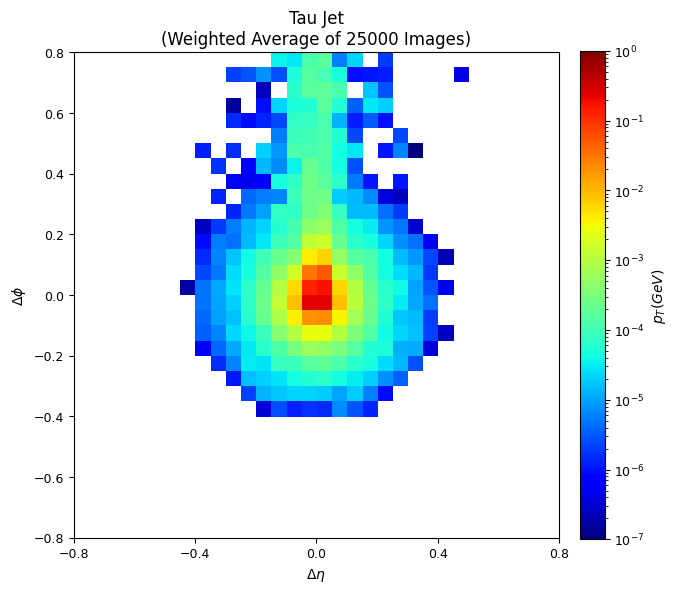

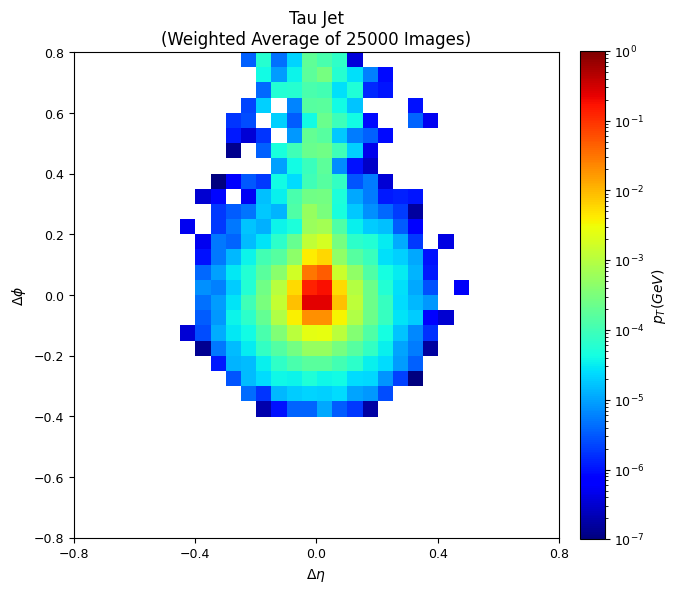

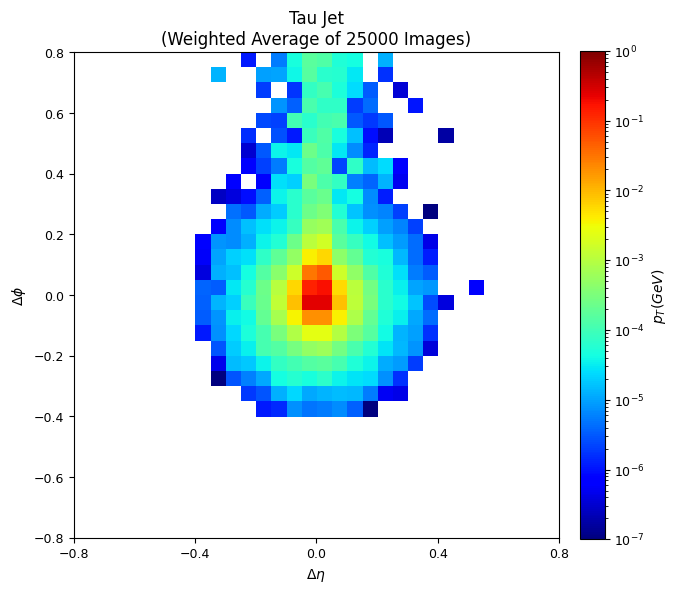

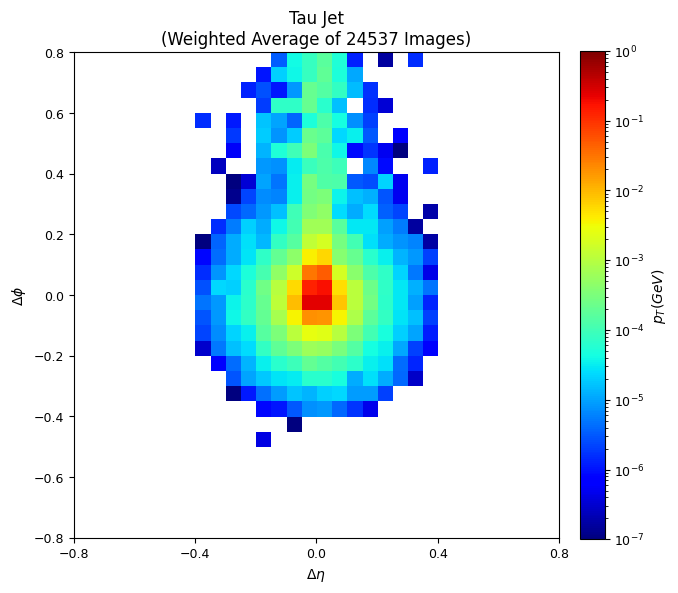

In [9]:
# Loop over both jet classes: 0 → Quark, 1 → Tau
for label in [0, 1]:
    # Create mask for current class and extract corresponding data
    class_mask = y == label
    X_class = X[class_mask]         # Jet images
    pT_class = pT[class_mask]       # Transverse momentum
    total = X_class.shape[0]        # Total jets in this class

    # Determine number of chunks based on avg_count threshold
    n_chunks = (total // avg_count) + int((total % avg_count) >= min_chunk_size)

    # Process each chunk individually
    for chunk_idx in range(n_chunks):
        start = chunk_idx * avg_count
        end = min((chunk_idx + 1) * avg_count, total)

        # Skip if chunk size is too small
        if end - start < min_chunk_size:
            print(f"Skipping small chunk {chunk_idx} for label {label}")
            continue

        # Extract images and corresponding pT for the chunk
        X_chunk = X_class[start:end]
        pT_chunk = pT_class[start:end]

        # Compute pT-weighted average image
        weights = pT_chunk / np.sum(pT_chunk)
        avg_img_weighted = np.average(X_chunk, axis=0, weights=weights)

        chunk_size = end - start  # Number of jets in this chunk

        # ─── Plot the Averaged Jet Image ────────────────────────────────────────
        fig, ax = plt.subplots(figsize=(7, 7))  # Set figure size in inches

        im = ax.imshow(
            avg_img_weighted,
            cmap='jet',
            origin='lower',
            aspect='equal',
            norm=LogNorm(vmin=1e-7, vmax=1),  # Log scale for better visualization
            extent=[eta_range_full[0], eta_range_full[1], phi_range_full[0], phi_range_full[1]]
        )

        # Annotate plot with title and axis labels
        ax.set_title(f"{class_names[label]} Jet\n(Weighted Average of {chunk_size} Images)", fontsize=12)
        ax.set_xlabel(r'$\Delta \eta$', fontsize=10)
        ax.set_ylabel(r'$\Delta \phi$', fontsize=10)
        ax.set_xticks(np.linspace(phi_range_full[0], phi_range_full[1], 5))
        ax.tick_params(labelsize=9)

        # Add colorbar to indicate pixel pT intensity
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(r'$p_{T} (GeV)$', fontsize=10)
        cbar.ax.tick_params(labelsize=9)

        # Save the figure to disk
        filename = f"{class_names[label].lower()}_avg_chunk{chunk_idx}.png"
        plt.tight_layout(pad=1.5)
        plt.savefig(average_jet_path / filename, bbox_inches='tight', dpi=300)

        # Display and close the figure to release memory
        plt.show()
        plt.close(fig)

In [10]:
def load_and_filter_core_batches(image_files, label_files, ratio_files, filter_labels, relabel_map):
    # Initialize lists to store filtered and concatenated data
    all_core_images = []
    all_core_labels = []
    all_core_pt_ratios = []
    all_core_charged_ratios = []

    # Iterate over corresponding image, label, and metadata files
    for img_file, lbl_file, ratio_file in zip(image_files, label_files, ratio_files):
        images = np.load(img_file)               # Load core jet images
        labels = np.load(lbl_file)               # Load class labels
        ratios_npz = np.load(ratio_file)         # Load metadata file (.npz format)

        # Extract core pT and charged particle ratios from metadata
        pt_ratios = ratios_npz["core_pt_ratio"]
        charged_ratios = ratios_npz["core_charged_ratio"]

        # Check consistency of lengths across arrays; truncate to smallest length if mismatch
        min_len = min(len(images), len(labels), len(pt_ratios), len(charged_ratios))
        if not (len(images) == len(labels) == len(pt_ratios) == len(charged_ratios)):
            print(f"Mismatch detected in batch: {img_file.name}")
            print(f"images: {len(images)}, labels: {len(labels)}, "
                  f"pt_ratios: {len(pt_ratios)}, charged_ratios: {len(charged_ratios)}")
            images = images[:min_len]
            labels = labels[:min_len]
            pt_ratios = pt_ratios[:min_len]
            charged_ratios = charged_ratios[:min_len]

        # Filter out unwanted labels (e.g., label 2 or 3)
        mask = ~np.isin(labels, filter_labels)
        filtered_images = images[mask]
        filtered_labels = labels[mask]
        filtered_pt_ratios = pt_ratios[mask]
        filtered_charged_ratios = charged_ratios[mask]

        # Relabel the remaining labels using provided mapping (e.g., {0: 0, 1: 1})
        new_labels = np.vectorize(relabel_map.get)(filtered_labels)

        # Accumulate batch data into the full dataset lists
        all_core_images.append(filtered_images)
        all_core_labels.append(new_labels)
        all_core_pt_ratios.append(filtered_pt_ratios)
        all_core_charged_ratios.append(filtered_charged_ratios)

    # Concatenate all batches into single NumPy arrays and return
    return (
        np.concatenate(all_core_images, axis=0),
        np.concatenate(all_core_labels, axis=0),
        np.concatenate(all_core_pt_ratios, axis=0),
        np.concatenate(all_core_charged_ratios, axis=0),
    )

In [11]:
# ─── Load Core Quark Jet File Paths ─────────────────────────────────────
core_qjet_img_files    = sorted(core_qjet_path.glob("core_images_batch_*_qjet.npy"))   # Core images
core_qjet_label_files  = sorted(core_qjet_path.glob("core_labels_batch_*_qjet.npy"))   # Corresponding labels
core_qjet_ratio_files  = sorted(core_qjet_path.glob("core_metadata_batch_*_qjet.npz")) # Core pT and charge ratios

# ─── Sanity Check ───────────────────────────────────────────────────────
# Ensure that for every batch there is an image, label, and metadata file
assert len(core_qjet_img_files) == len(core_qjet_label_files) == len(core_qjet_ratio_files), \
    "Mismatch in number of QJet core files!"

# ─── Label Filtering and Relabeling ─────────────────────────────────────
core_qjet_filter_labels = [2, 3]         # Filter out unwanted labels (e.g., gluons or unmatched)
core_qjet_relabel_map = {0: 0, 1: 0}     # Merge all remaining quark-like labels into class 0

# ─── Load and Filter Core Quark Jet Batches ─────────────────────────────
core_qjet_images, core_qjet_labels, core_qjet_pt_ratios, core_qjet_charged_ratios = load_and_filter_core_batches(
    core_qjet_img_files,
    core_qjet_label_files,
    core_qjet_ratio_files,
    core_qjet_filter_labels,
    core_qjet_relabel_map
)

# ─── Logging ────────────────────────────────────────────────────────────
log_merge(f"Core QJets Loaded: {core_qjet_images.shape[0]} jets")  # Print number of successfully loaded jets

[2025-04-22 12:40:16] Core QJets Loaded: 96079 jets


In [12]:
# ─── Load Core Tau Jet File Paths ───────────────────────────────────────
core_taujet_img_files    = sorted(core_taujet_path.glob("core_images_batch_*_taujet.npy"))   # Core images
core_taujet_label_files  = sorted(core_taujet_path.glob("core_labels_batch_*_taujet.npy"))   # Corresponding labels
core_taujet_ratio_files  = sorted(core_taujet_path.glob("core_metadata_batch_*_taujet.npz")) # Core pT and charge ratios

# ─── Sanity Check ───────────────────────────────────────────────────────
# Ensure all batches have consistent number of files
assert len(core_taujet_img_files) == len(core_taujet_label_files) == len(core_taujet_ratio_files), \
    "Mismatch in number of TauJet core files!"

# ─── Label Filtering and Relabeling ─────────────────────────────────────
core_taujet_filter_labels = [2]         # Remove label 2 jets if present (e.g., unmatched)
core_taujet_relabel_map = {0: 1, 1: 1}  # Merge all tau-like labels into class 1

# ─── Load and Filter Core Tau Jet Batches ───────────────────────────────
core_taujet_images, core_taujet_labels, core_taujet_pt_ratios, core_taujet_charged_ratios = load_and_filter_core_batches(
    core_taujet_img_files,
    core_taujet_label_files,
    core_taujet_ratio_files,
    core_taujet_filter_labels,
    core_taujet_relabel_map
)

# ─── Logging ────────────────────────────────────────────────────────────
log_merge(f"Core Tau Jets Loaded: {core_taujet_images.shape[0]} jets")  # Print total number of loaded core tau jets

[2025-04-22 12:40:17] Core Tau Jets Loaded: 123683 jets


In [13]:
# ─── Merge Core Jet Data ────────────────────────────────────────────────
# Combine tau and quark core jet data: images, labels, and metadata
core_X = np.concatenate([core_taujet_images, core_qjet_images], axis=0)
core_y = np.concatenate([core_taujet_labels, core_qjet_labels], axis=0)
core_pt_ratios = np.concatenate([core_taujet_pt_ratios, core_qjet_pt_ratios], axis=0)
core_charged_ratios = np.concatenate([core_taujet_charged_ratios, core_qjet_charged_ratios], axis=0)

# Shuffle the full dataset to randomize ordering
core_X, core_y, core_pt_ratios, core_charged_ratios = shuffle(
    core_X, core_y, core_pt_ratios, core_charged_ratios, random_state=42
)

# ─── Save Final Core Jet Dataset ────────────────────────────────────────
np.save(core_jet_npy_file_path / "core_jet_images.npy", core_X)
np.save(core_jet_npy_file_path / "core_jet_labels.npy", core_y)
np.savez(core_jet_npy_file_path / "core_jet_metadata.npz", 
         core_pt_ratio=core_pt_ratios, 
         core_charged_ratio=core_charged_ratios)

# ─── Logging Summary Information ────────────────────────────────────────
log_merge("\n================ CORE JET DATASET =================")
log_merge(f"Total core dataset: {core_X.shape[0]} jets")
log_merge(f"Image shape: {core_X.shape}")
log_merge(f"Label shape: {core_y.shape}")
log_merge(f"pT ratio shape: {core_pt_ratios.shape}")
log_merge(f"Charged ratio shape: {core_charged_ratios.shape}")

# Print class distribution
class_names = {0: "Quark", 1: "Tau"}
unique, counts = np.unique(core_y, return_counts=True)

log_merge("\nClass distribution:")
for label, count in zip(unique, counts):
    percent = (count / len(core_y)) * 100
    log_merge(f"  {class_names[label]}: {count} jets  ({percent:.3f}%)")

# Print intensity statistics across all core images
log_merge("\nPixel intensity statistics (core images):")
log_merge(f"Min intensity:   {np.min(core_X):.5f}")
log_merge(f"Max intensity:   {np.max(core_X):.5f}")
log_merge(f"Mean intensity:  {np.mean(core_X):.5f}")
log_merge(f"Std deviation:   {np.std(core_X):.5f}")

# Print global statistics for core pT and charged ratios
log_merge("\nCore pT Ratio statistics:")
log_merge(f"Min:   {np.min(core_pt_ratios):.5f}")
log_merge(f"Max:   {np.max(core_pt_ratios):.5f}")
log_merge(f"Mean:  {np.mean(core_pt_ratios):.5f}")
log_merge(f"Std:   {np.std(core_pt_ratios):.5f}")

log_merge("\nCore Charged Multiplicity Ratio statistics:")
log_merge(f"Min:   {np.min(core_charged_ratios):.5f}")
log_merge(f"Max:   {np.max(core_charged_ratios):.5f}")
log_merge(f"Mean:  {np.mean(core_charged_ratios):.5f}")
log_merge(f"Std:   {np.std(core_charged_ratios):.5f}")

# ─── Per-Class Core Ratio Stats ─────────────────────────────────────────
for label in [0, 1]:
    label_mask = core_y == label
    label_pt = core_pt_ratios[label_mask]
    label_charged = core_charged_ratios[label_mask]

    log_merge(f"\nCore pT Ratio stats for {class_names[label]} jets:")
    log_merge(f"Min:   {np.min(label_pt):.5f}")
    log_merge(f"Max:   {np.max(label_pt):.5f}")
    log_merge(f"Mean:  {np.mean(label_pt):.5f}")
    log_merge(f"Std:   {np.std(label_pt):.5f}")

    log_merge(f"\nCore Charged Ratio stats for {class_names[label]} jets:")
    log_merge(f"Min:   {np.min(label_charged):.5f}")
    log_merge(f"Max:   {np.max(label_charged):.5f}")
    log_merge(f"Mean:  {np.mean(label_charged):.5f}")
    log_merge(f"Std:   {np.std(label_charged):.5f}")

# Final confirmation log
log_merge("Core jet dataset saved successfully.\n")

[2025-04-22 12:40:18] 
================ CORE JET DATASET =================
[2025-04-22 12:40:18] Total core dataset: 219762 jets
[2025-04-22 12:40:18] Image shape: (219762, 20, 20)
[2025-04-22 12:40:18] Label shape: (219762,)
[2025-04-22 12:40:18] pT ratio shape: (219762,)
[2025-04-22 12:40:18] Charged ratio shape: (219762,)
[2025-04-22 12:40:18] 
Class distribution:
[2025-04-22 12:40:18]   Quark: 96079 jets  (43.720%)
[2025-04-22 12:40:18]   Tau: 123683 jets  (56.280%)
[2025-04-22 12:40:18] 
Pixel intensity statistics (core images):
[2025-04-22 12:40:18] Min intensity:   0.00000
[2025-04-22 12:40:18] Max intensity:   1.00000
[2025-04-22 12:40:18] Mean intensity:  0.00250
[2025-04-22 12:40:19] Std deviation:   0.03154
[2025-04-22 12:40:19] 
Core pT Ratio statistics:
[2025-04-22 12:40:19] Min:   0.00000
[2025-04-22 12:40:19] Max:   1.00000
[2025-04-22 12:40:19] Mean:  0.90584
[2025-04-22 12:40:19] Std:   0.14819
[2025-04-22 12:40:19] 
Core Charged Multiplicity Ratio statistics:
[2025-04

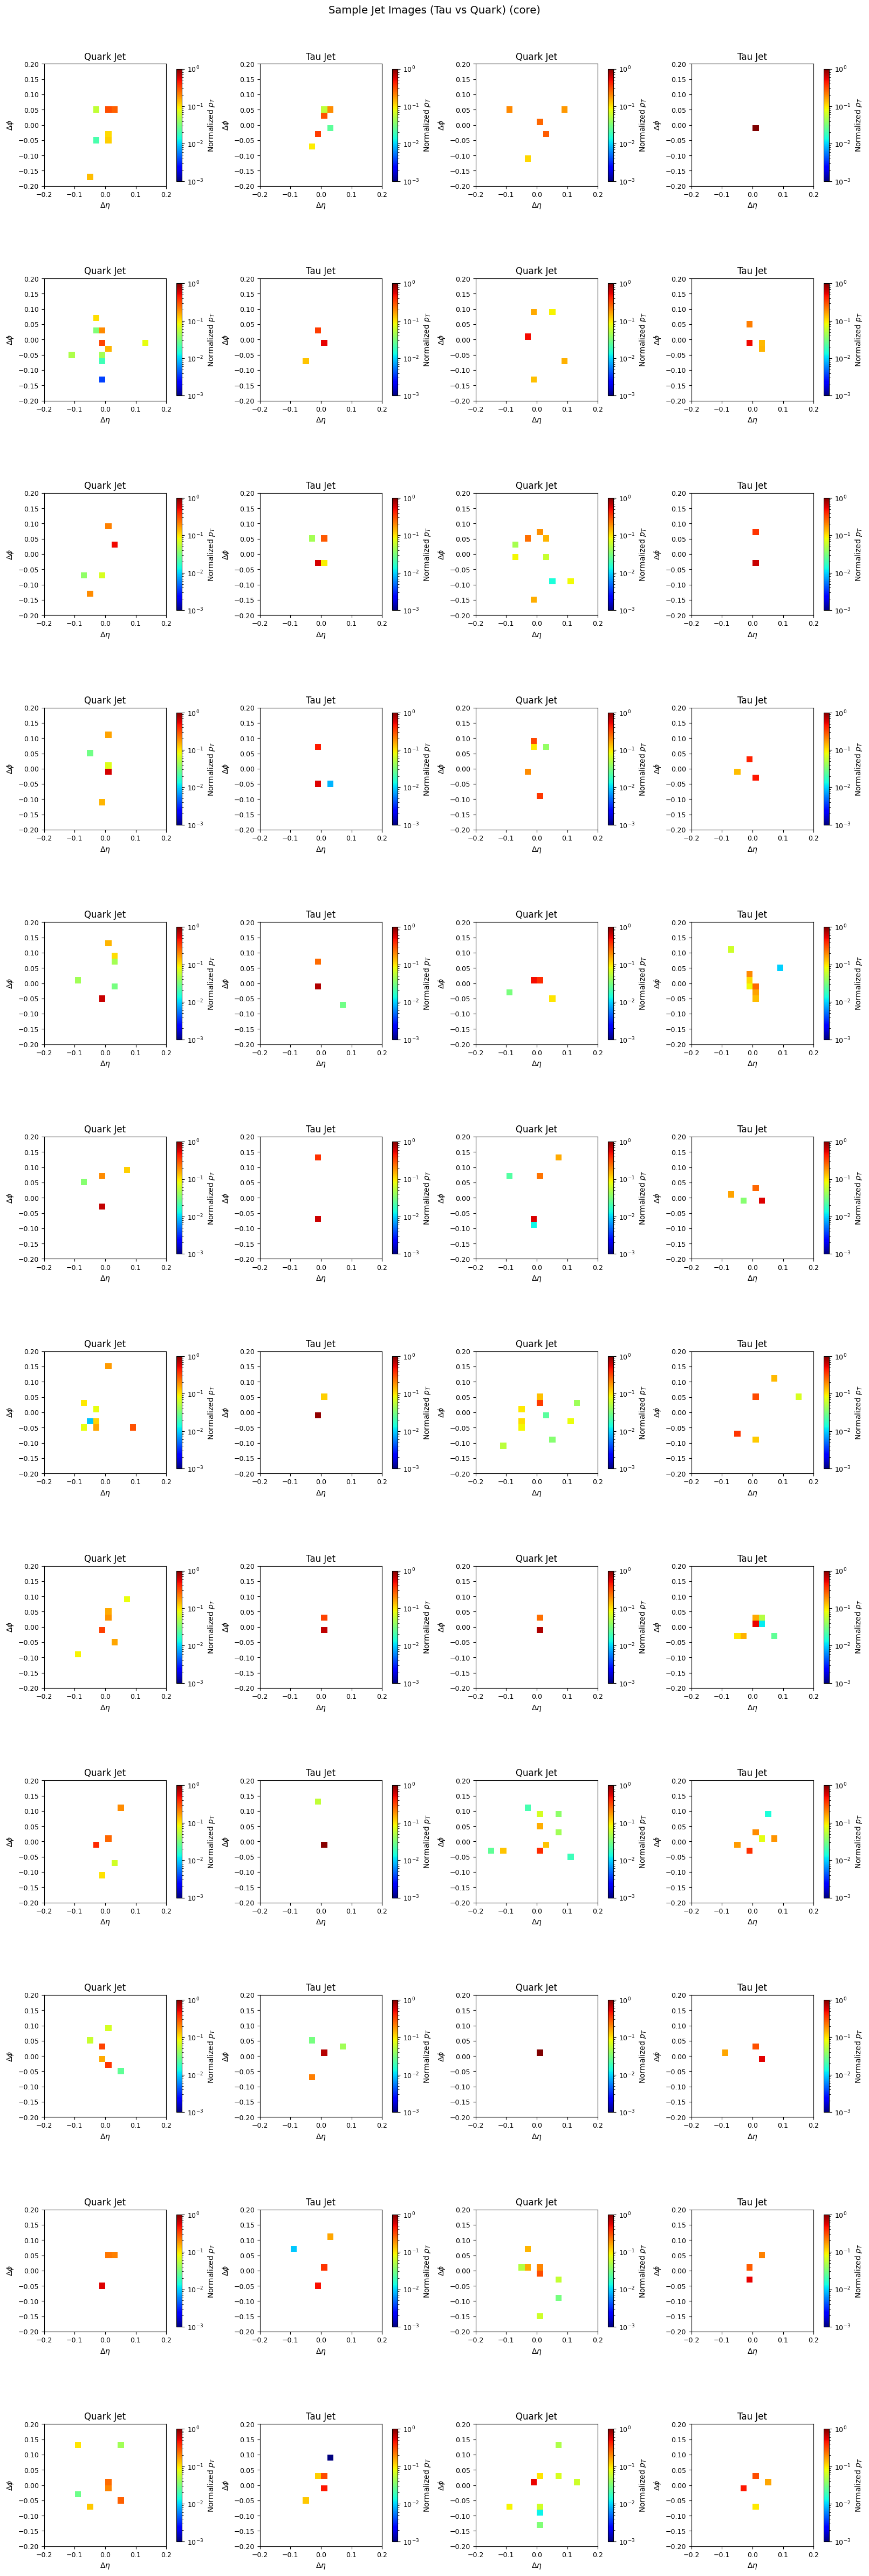

In [14]:
# ─── Select Sample Core Jet Indices ───────────────────────────────────────
# Store 'samples_per_class' number of jet indices for each class (0: Quark, 1: Tau)
core_class_indices = {label: [] for label in range(2)}

for idx, label in enumerate(core_y):
    if len(core_class_indices[label]) < samples_per_class:
        core_class_indices[label].append(idx)
    if all(len(v) == samples_per_class for v in core_class_indices.values()):
        break  # Stop once enough samples from both classes are collected

# ─── Ensure Output Directory Exists ───────────────────────────────────────
core_img_path.mkdir(parents=True, exist_ok=True)

# Interleave indices so jets appear alternately in plots (tau, quark, tau, ...)
core_ordered_indices = []
for i in range(samples_per_class):
    for label in range(2):
        core_ordered_indices.append(core_class_indices[label][i])

core_saved_count = {0: 0, 1: 0}  # Count images saved per class

# ─── Create Combined Figure Grid for Sample Core Jet Images ──────────────
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), constrained_layout=True)

for plot_idx, data_idx in enumerate(core_ordered_indices):
    row = plot_idx // n_cols
    col = plot_idx % n_cols
    ax = axs[row, col]

    label = core_y[data_idx]
    class_name = class_names[label]
    
    # Display jet image on subplot with color map and axis labels
    im = ax.imshow(core_X[data_idx], cmap='jet', origin='lower', aspect='equal', 
                   norm=LogNorm(vmin=1e-3, vmax=1),
                   extent=[eta_range_core[0], eta_range_core[1], phi_range_core[0], phi_range_core[1]])
    ax.set_title(f"{class_name.capitalize()} Jet", fontsize=12)
    ax.set_xlabel(r'$\Delta \eta$', fontsize=10)
    ax.set_ylabel(r'$\Delta \phi$', fontsize=10)
    ax.tick_params(labelsize=9)

    # Add colorbar indicating normalized pT values
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(r'Normalized $p_{T}$', fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    # ─── Save Individual Core Jet Image ────────────────────────────────────
    fig_single, ax_single = plt.subplots()
    im_single = ax_single.imshow(core_X[data_idx], cmap='jet', origin='lower', aspect='equal', 
                                 norm=LogNorm(vmin=1e-3, vmax=1), 
                                 extent=[eta_range_core[0], eta_range_core[1], phi_range_core[0], phi_range_core[1]])
    ax_single.set_title(f"{class_name.capitalize()} Jet", fontsize=10)
    ax_single.set_xlabel(r'$\Delta \eta$', fontsize=10)
    ax_single.set_ylabel(r'$\Delta \phi$', fontsize=10)
    ax_single.tick_params(labelsize=9)

    cbar_single = plt.colorbar(im_single, ax=ax_single, fraction=0.046, pad=0.04)
    cbar_single.set_label(r'$p_{T}$ (GeV)', fontsize=10)
    cbar_single.ax.tick_params(labelsize=9)

    filename = f"{class_name.lower()}_corejet_{core_saved_count[label]}.png"
    plt.savefig(core_img_path / filename, bbox_inches='tight')  # Save image to disk
    plt.close(fig_single)

    core_saved_count[label] += 1  # Increment save count for this class

# ─── Show Combined Sample Jet Grid ────────────────────────────────────────
plt.suptitle("Sample Jet Images (Tau vs Quark) (core)", fontsize=14)
plt.show()

Processing label 0, chunk 0, jets: 25000


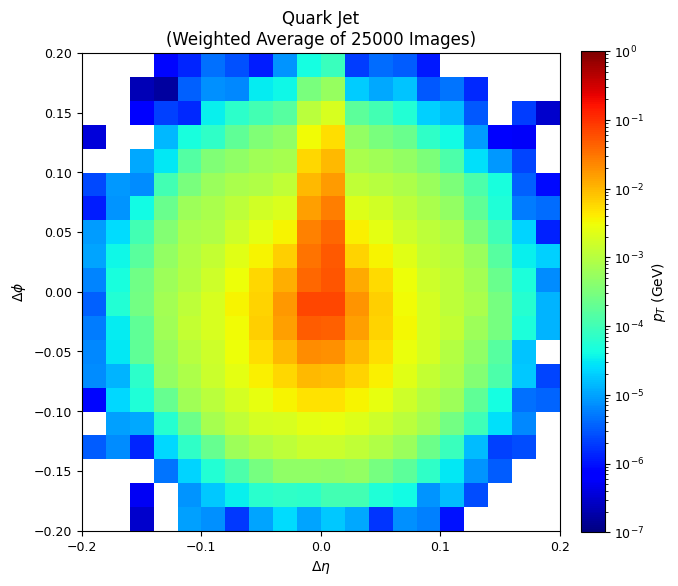

Processing label 0, chunk 1, jets: 25000


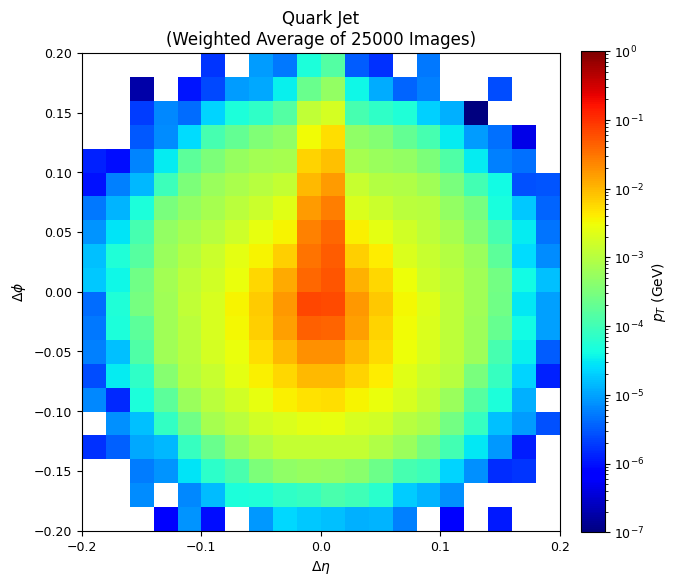

Processing label 0, chunk 2, jets: 25000


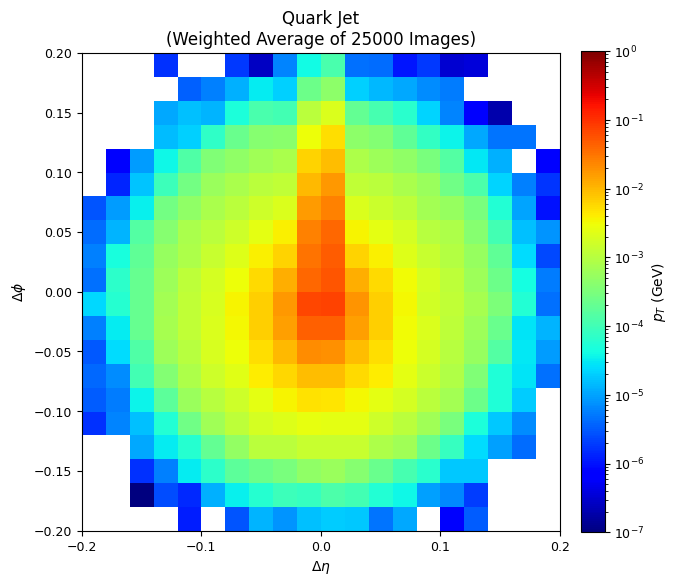

Processing label 0, chunk 3, jets: 21079


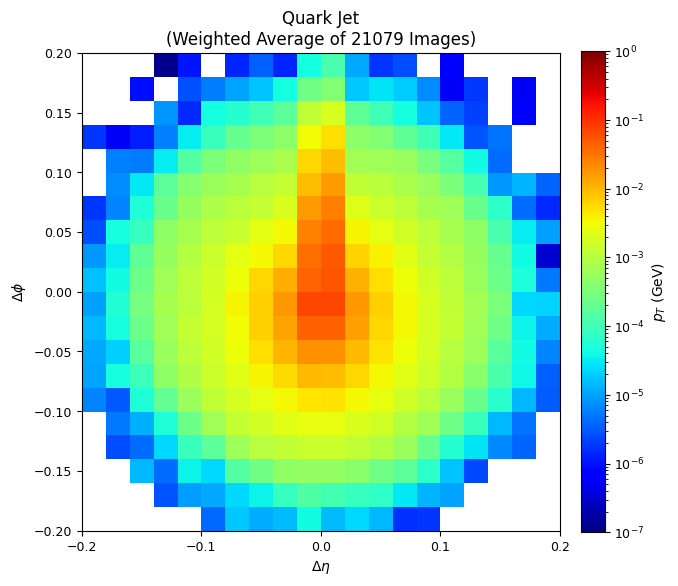

Processing label 1, chunk 0, jets: 25000


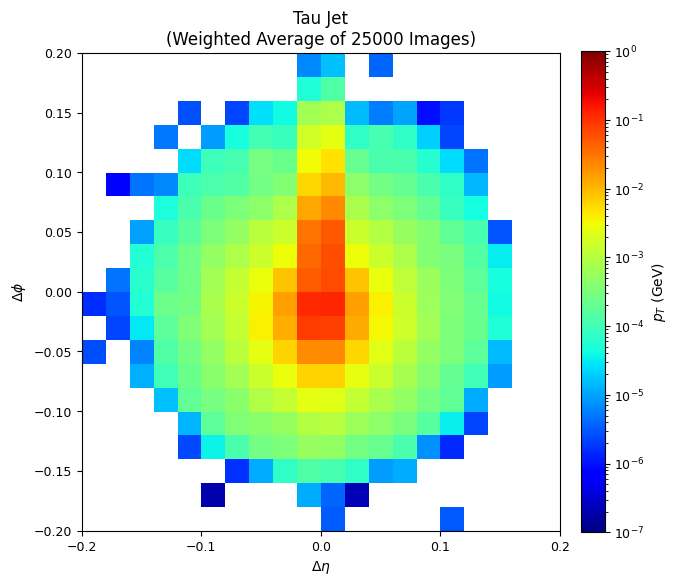

Processing label 1, chunk 1, jets: 25000


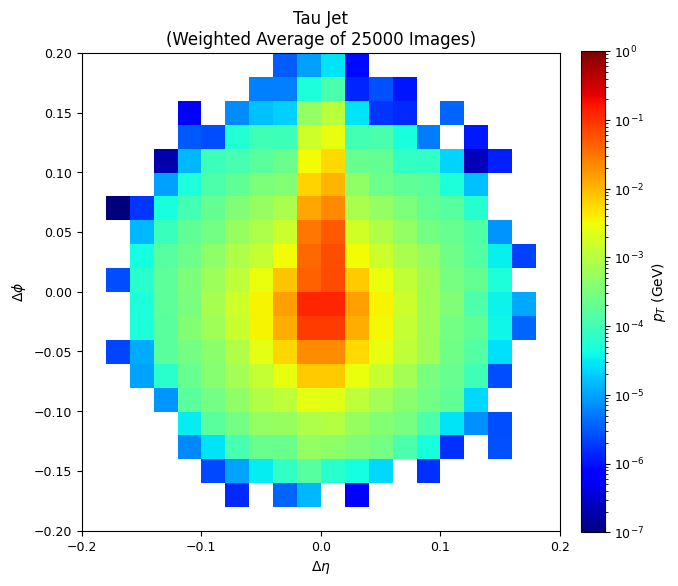

Processing label 1, chunk 2, jets: 25000


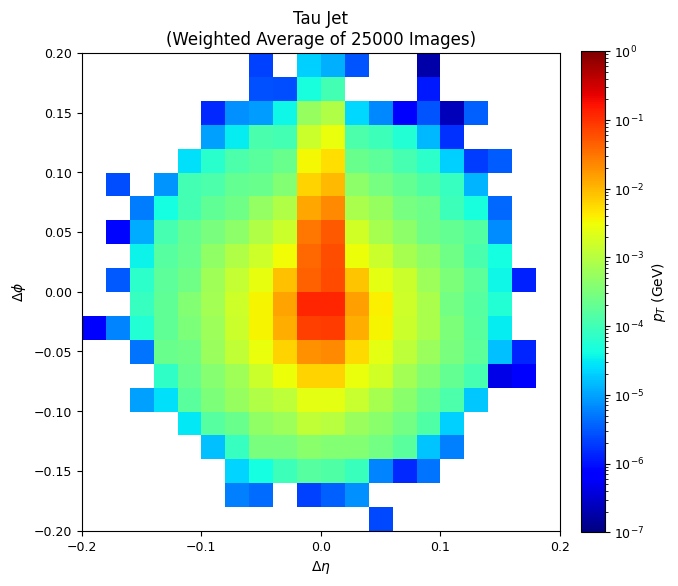

Processing label 1, chunk 3, jets: 25000


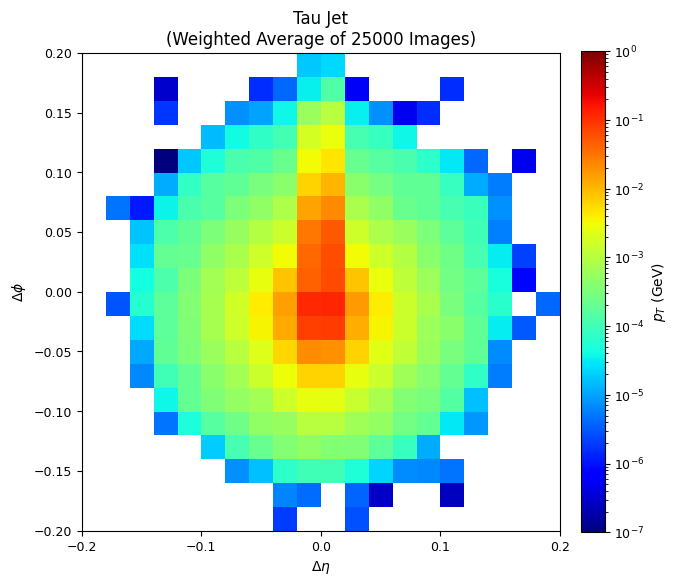

Processing label 1, chunk 4, jets: 23683


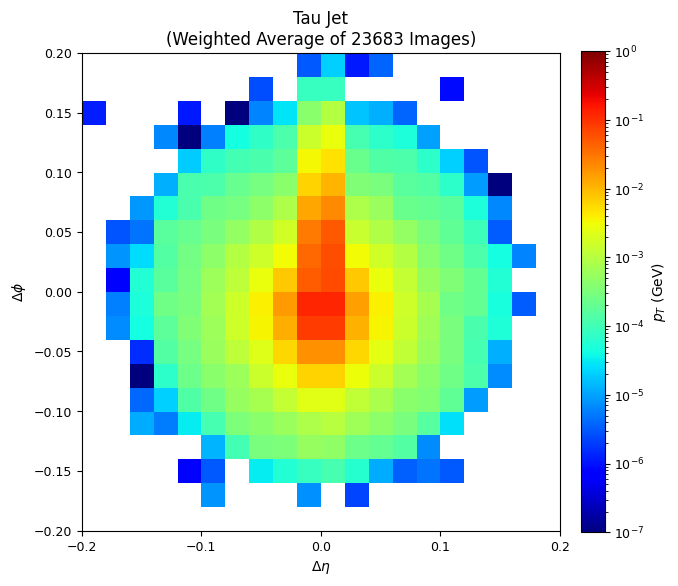

In [15]:
# Loop over both jet classes: 0 (Quark), 1 (Tau)
for label in [0, 1]:
    # Create a mask for current class
    core_class_mask = core_y == label
    core_X_class = core_X[core_class_mask]                  # Core images for the class
    core_pT_class = core_pt_ratios[core_class_mask]         # Corresponding core pT ratios

    total_core = core_X_class.shape[0]                      # Total jets in this class
    # Calculate number of chunks to process for averaging
    n_chunks_core = (total_core // avg_count) + int((total_core % avg_count) >= min_chunk_size)

    for chunk_idx in range(n_chunks_core):
        # Determine chunk start and end indices
        start = chunk_idx * avg_count
        end = min((chunk_idx + 1) * avg_count, total_core)
        chunk_size = end - start

        # Skip chunks that are too small for meaningful averaging
        if chunk_size < min_chunk_size:
            print(f"Skipping small core chunk {chunk_idx} for label {label}")
            continue

        # Extract the chunk of core jet images and their weights
        core_X_chunk = core_X_class[start:end]
        core_pT_chunk = core_pT_class[start:end]

        # Use pT ratios as weights for weighted averaging
        weights = core_pT_chunk / np.sum(core_pT_chunk)
        avg_core_img_weighted = np.average(core_X_chunk, axis=0, weights=weights)

        print(f"Processing label {label}, chunk {chunk_idx}, jets: {chunk_size}")

        # Plot the weighted average image
        fig, ax = plt.subplots(figsize=(7, 7))  # Larger figure for clarity

        im = ax.imshow(
            avg_core_img_weighted,
            cmap='jet',
            origin='lower',
            aspect='equal',
            norm=LogNorm(vmin=1e-7, vmax=1),
            extent=[eta_range_core[0], eta_range_core[1], phi_range_core[0], phi_range_core[1]]
        )

        # Set axis titles and labels
        ax.set_title(f"{class_names[label]} Jet\n(Weighted Average of {chunk_size} Images)", fontsize=12)
        ax.set_xlabel(r'$\Delta \eta$', fontsize=10)
        ax.set_ylabel(r'$\Delta \phi$', fontsize=10)
        ax.set_xticks(np.linspace(phi_range_core[0], phi_range_core[1], 5))
        ax.tick_params(labelsize=9)

        # Add colorbar to indicate normalized transverse momentum
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(r'$p_{T}$ (GeV)', fontsize=10)
        cbar.ax.tick_params(labelsize=9)

        # Save the figure to disk
        filename = f"{class_names[label].lower()}_core_avg_chunk{chunk_idx}.png"
        plt.tight_layout(pad=1.5)  # Adjust layout before saving
        plt.savefig(average_core_img_path / filename, bbox_inches='tight', dpi=300)
        plt.show()
        plt.close(fig)